Data Cleaning & Visualization - NYC Citi Bike Itinerary Data (2016-01 ~ 06) 
-----------
<img src='./citi-bike.jpg' alt="Drawing" style="width: 600px;"/>

This notebook covers basic EDA for NYC citibike dataset including, 
    1. Data cleaning

[Prepare dataset](#prepare-dataset)  
[Basic Information](#basic-information)  
[Distribution of features](#distribution)  
[Segmentation ( categorical - numerical values)](#segmentation)  
[Correlation between numerical features](#correlation)  
[Filling missing values](#filling-missing-values)  

    2. Visualization  
[Subscription users vs Day-pass users](#visualization1)
[Animated maps by time](#visualization2)

### Dataset 
Citi bank provides NYC citibike trip data for free and you can find it here https://s3.amazonaws.com/tripdata/index.html
#### Data Dictionary 
- Trip Duration (seconds)
- Start Time and Date
- Stop Time and Date
- Start Station Name
- End Station Name
- Station ID
- Station Lat/Long
- Bike ID
- User Type (Customer = 24-hour pass or 3-day pass user; Subscriber = Annual Member)
- Gender (Zero=unknown; 1=male; 2=female)
- Year of Birth

Data Cleaning
-----------

<a id='prepare-dataset'></a>
### Prepare dataset

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
import folium
import os
import io
import re

In [2]:
path = "./input"
df_arr = []

for filename in os.listdir(path):
    if re.match(r'JC-2016(0){0,1}\d-citibike-tripdata.csv', filename):
        print('Add \'{}\' into dataframe.. '.format(filename))
        df = pd.read_csv(os.path.join(path, filename))
        df_arr.append(df)

Add 'JC-20161-citibike-tripdata.csv' into dataframe.. 
Add 'JC-20163-citibike-tripdata.csv' into dataframe.. 
Add 'JC-201606-citibike-tripdata.csv' into dataframe.. 
Add 'JC-201604-citibike-tripdata.csv' into dataframe.. 
Add 'JC-20162-citibike-tripdata.csv' into dataframe.. 
Add 'JC-201605-citibike-tripdata.csv' into dataframe.. 


In [3]:
# Concatenate monthly dataset into one 
trip_data_half = pd.concat(df_arr)

<a id='basic-information'></a>

### Basic Information

In [4]:
# Dataframe dimensions
trip_data_half.shape

(89017, 15)

In [5]:
# Turning Start Time and Stop Time columns into datetime object 
trip_data_half['Start Time'] = pd.to_datetime(trip_data_half['Start Time'])
trip_data_half['Stop Time'] = pd.to_datetime(trip_data_half['Stop Time'])

In [6]:
# Dataframe dataset
trip_data_half.dtypes

Trip Duration                       int64
Start Time                 datetime64[ns]
Stop Time                  datetime64[ns]
Start Station ID                    int64
Start Station Name                 object
Start Station Latitude            float64
Start Station Longitude           float64
End Station ID                      int64
End Station Name                   object
End Station Latitude              float64
End Station Longitude             float64
Bike ID                             int64
User Type                          object
Birth Year                        float64
Gender                              int64
dtype: object

In [7]:
# First 5 rows of the dataframe 
trip_data_half.head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
0,362,2016-01-01 00:02:52,2016-01-01 00:08:54,3186,Grove St PATH,40.719586,-74.043117,3209,Brunswick St,40.724176,-74.050656,24647,Subscriber,1964.0,2
1,200,2016-01-01 00:18:22,2016-01-01 00:21:42,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24605,Subscriber,1962.0,1
2,202,2016-01-01 00:18:25,2016-01-01 00:21:47,3186,Grove St PATH,40.719586,-74.043117,3213,Van Vorst Park,40.718489,-74.047727,24689,Subscriber,1962.0,2
3,248,2016-01-01 00:23:13,2016-01-01 00:27:21,3209,Brunswick St,40.724176,-74.050656,3203,Hamilton Park,40.727596,-74.044247,24693,Subscriber,1984.0,1
4,903,2016-01-01 01:03:20,2016-01-01 01:18:24,3195,Sip Ave,40.730743,-74.063784,3210,Pershing Field,40.742677,-74.051789,24573,Customer,NaN,0


<a id='distribution'></a>

### Distribution

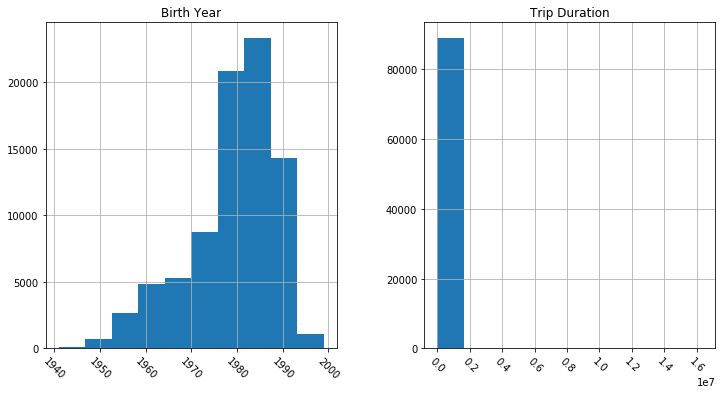

In [8]:
# Numerical data 
trip_data_half[['Trip Duration', 'Birth Year']].hist(figsize=(12,6), xrot=-45)
plt.show()

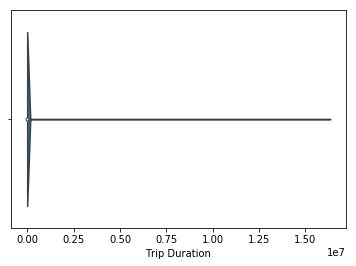

In [9]:
sns.violinplot(trip_data_half['Trip Duration'])
plt.show()

We can see that the distribution of 'Trip Duration' is highly left-skewed, which means there's potential outliers.
I think most of people ride no more than an hour. Let's find out what percentage of trips in the dataset taken more than a hour.  

In [10]:
print('Maximum value of trip duration : {} days'.format(round(trip_data_half['Trip Duration'].max()/3600*12, 2)))
print('There are {} trips taken less than an hour'.format(trip_data_half[trip_data_half['Trip Duration'] <= 3600].shape[0]))
print('And it is {}% out of the whold dataset'.format(round(trip_data_half[trip_data_half['Trip Duration'] <= 3600]
                                                        .shape[0]*100/trip_data_half.shape[0],2)))

Maximum value of trip duration : 54432.69 days
There are 87583 trips taken less than an hour
And it is 98.39% out of the whold dataset


It's s safe to remove rows which has 'Trip Duration' > 3600

In [11]:
trip_data_half = trip_data_half[trip_data_half['Trip Duration'] <= 3600]

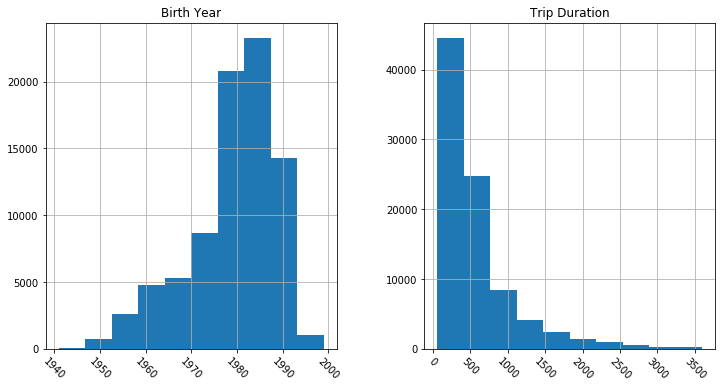

In [12]:
# Distribution after outliers removed
trip_data_half[['Trip Duration', 'Birth Year']].hist(figsize=(12,6), xrot=-45)
plt.show()

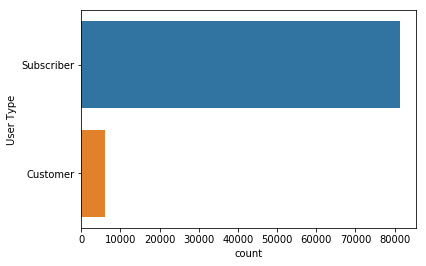

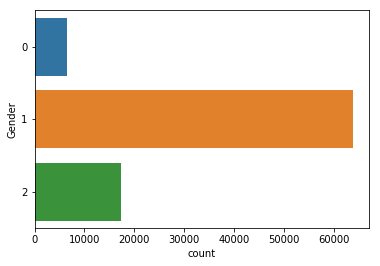

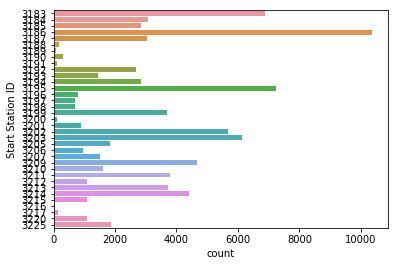

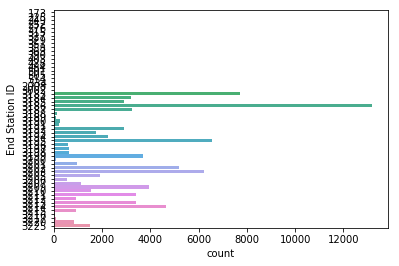

In [13]:
# categorical data 
for feature in ['User Type', 'Gender', 'Start Station ID', 'End Station ID']:
    sns.countplot(data=trip_data_half, y=feature)
    plt.show()

- Obviously, subscribers ride more frequently than day-pass users do
- Gender 1 most frequently use citi bike
- It's hard to tell something from Start/End station value counts plot

In [14]:
# Start & End Stations value counts dataframe 
pd.merge(pd.DataFrame(trip_data_half['Start Station ID'].value_counts()), pd.DataFrame(trip_data_half['End Station ID'].value_counts()), how='outer',
         left_index=True, right_index=True).sort_values(by=['Start Station ID'], ascending=False)

,Start Station ID,End Station ID
3186,10377.0,13200
3195,7225.0,6558
3183,6875.0,7704
3203,6138.0,6207
3202,5670.0,5201
3209,4661.0,3931
3214,4399.0,4656
3211,3783.0,3428
3213,3733.0,3431
3199,3692.0,3711


- In general, for each station, the frequency of start station is simliar to that of end station. People might make a round trip with citi bike. 
- However, there are also stations where people never start a trip but made a end to that point. 

<a id='segmentation'></a>

### Segmentation

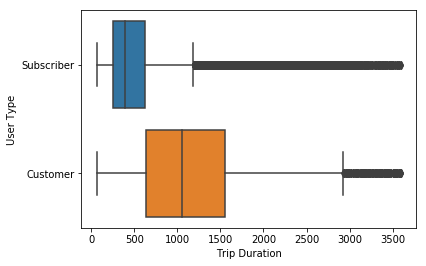

In [15]:
# Segment Trip Duration by User Type and plot distributions
sns.boxplot(y='User Type', x='Trip Duration', data=trip_data_half)
plt.show()

In [16]:
trip_data_half.groupby(['User Type'])[['Trip Duration', 'Birth Year']].mean()

,Trip Duration,Birth Year
User Type,,
Customer,1180.637139,NaN
Subscriber,528.715652,1979.148277


Customer group has no birth date info because they don't need to go through sign up process.

- Which type of customer travels longer, on average? -Customers (those who without subsciption) do.
- Which type of customer sees greater variance in trip duration? -Customers do.
- Which type of customer sees greater outlier data points in trip duration? -Customers do. 
- Does the difference in distributions between classes make intuitive sense? - Yes. In general, annual members are usually New York locals and 3-day pass tickets are targeted for tourists or visitors. They tend to make the most of their day pass, which leads to longer travel time. On the other hand, annual subscribers don't bother to make a long trip because they know they will use it more frequently, albeit for a short time. This is interesting because citi bike offers free 15 mins more for subscribers(first 30mins for free for day pass & 45mins for subscribers)

<a id='correlation'></a>

#### Correlation between numerical features 

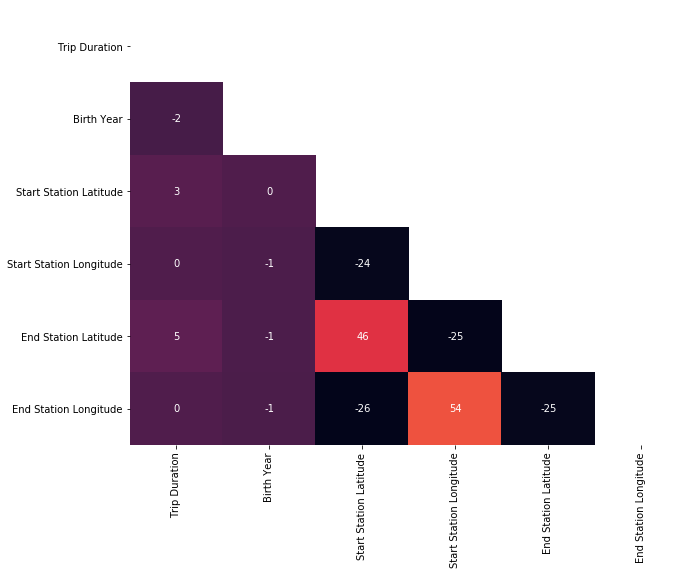

In [17]:
# Generate a mask for the upper triangle
df = trip_data_half[['Trip Duration', 'Birth Year'
                     , 'Start Station Latitude', 'Start Station Longitude'
                    , 'End Station Latitude', 'End Station Longitude']]
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Make the figsize 10 x 8
plt.figure(figsize=(10, 8))
# Plot heatmap of correlations
sns.heatmap(df.corr()*100, fmt='.0f', annot=True, mask=mask, cbar=False)

There's no clear correlation relationship between numerical values 

<a id='filling-missing-values'></a>

### Filling missing values

In [18]:
# missing data 
trip_data_half.isnull().sum()

Trip Duration                 0
Start Time                    0
Stop Time                     0
Start Station ID              0
Start Station Name            0
Start Station Latitude        0
Start Station Longitude       0
End Station ID                0
End Station Name              0
End Station Latitude          0
End Station Longitude         0
Bike ID                       0
User Type                    55
Birth Year                 6140
Gender                        0
dtype: int64

In [19]:
# Missing one persons' data 
# Same birth year, gender, Repeated stations
# -> fill it as subscriber
trip_data_half[trip_data_half['User Type'].isnull()].head()

,Trip Duration,Start Time,Stop Time,Start Station ID,Start Station Name,Start Station Latitude,Start Station Longitude,End Station ID,End Station Name,End Station Latitude,End Station Longitude,Bike ID,User Type,Birth Year,Gender
9538,156,2016-03-23 09:08:34,2016-03-23 09:11:11,3214,Essex Light Rail,40.712774,-74.036486,3183,Exchange Place,40.716247,-74.033459,24444,NaN,1987.0,1
9939,164,2016-03-23 22:17:45,2016-03-23 22:20:29,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,-74.036486,24675,NaN,1987.0,1
10165,171,2016-03-24 11:46:39,2016-03-24 11:49:31,3214,Essex Light Rail,40.712774,-74.036486,3183,Exchange Place,40.716247,-74.033459,24697,NaN,1987.0,1
10460,204,2016-03-24 20:45:45,2016-03-24 20:49:10,3183,Exchange Place,40.716247,-74.033459,3214,Essex Light Rail,40.712774,-74.036486,24387,NaN,1987.0,1
10901,380,2016-03-25 19:15:56,2016-03-25 19:22:17,3183,Exchange Place,40.716247,-74.033459,3184,Paulus Hook,40.714145,-74.033552,24412,NaN,1987.0,1


In [20]:
# fill missing categorical feature 
trip_data_half['User Type'].fillna('Subscriber', inplace=True)

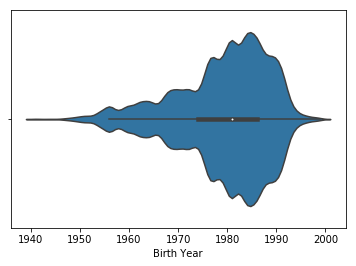

In [21]:
# fill missing numerical feature 
sns.violinplot(trip_data_half['Birth Year'])
plt.show()

In [22]:
# fill missing age values with the mean of the 5 most frequent birth year 
most_freq = int(np.mean(trip_data_half['Birth Year'].value_counts().head().index.tolist()))
trip_data_half['Birth Year'].fillna(most_freq, inplace=True)

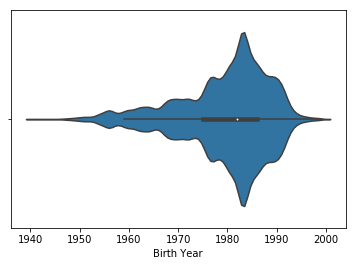

In [23]:
sns.violinplot(trip_data_half['Birth Year'])
plt.show()

Visualizaition
---------------
This part is inspired by https://github.com/vincentropy/python_cartography_tutorial/

<a id='visualization1'></a>
### Itineary difference between subscribers vs day-pass users 

In [24]:
# generate dataframe of station info by user type 
def get_trip_counts_by_user_type(user_type):
    locations = trip_data_half.groupby("End Station ID").first()
    locations = locations.loc[:, ["End Station Latitude",
                                 "End Station Longitude",
                                 "End Station Name"]]
    
    subset = trip_data_half[trip_data_half['User Type']==user_type]
    
    # count trips for each origin
    departure_counts = subset.groupby('Start Station ID').count().iloc[:, [0]]
    departure_counts.columns = ['Departure Count']
    
    # count trips for each destination
    arrival_counts = subset.groupby('End Station ID').count().iloc[:, [0]]
    arrival_counts.columns= ["Arrival Count"]
    
    # join dataframes 
    trip_counts = arrival_counts.join(departure_counts).join(locations)
    trip_counts.columns = ['Arrival Count',  'Departure Count',
                           'Latitude', 'Longitude', 
                         'Station Name']
    
    # fill NaN with 0 where 
    trip_counts['Departure Count'].fillna(0, inplace=True)
    return trip_counts.sort_values(by='Arrival Count', ascending=False)   

In [25]:
get_trip_counts_by_user_type('Subscriber').head()

,Arrival Count,Departure Count,Latitude,Longitude,Station Name
End Station ID,,,,,
3186,12803,9980.0,40.719586,-74.043117,Grove St PATH
3183,6995,6177.0,40.716247,-74.033459,Exchange Place
3195,6341,6998.0,40.730743,-74.063784,Sip Ave
3203,5953,5889.0,40.727596,-74.044247,Hamilton Park
3202,4733,5196.0,40.727224,-74.033759,Newport PATH


In [26]:
# Generate folium map 
def plot_station_counts(trip_counts):
    # center location - the most visited station #3186
    folium_map = folium.Map(location=[40.719586, -74.043117],
                           zoom_start=13, 
                           tiles='CartoDB dark_matter',
                           width='50%')
    for index, row in trip_counts.iterrows():
        net_departures = (row['Departure Count']-row['Arrival Count'])
        
        popup_text = "{} total departures:{}\ntotal arrivals: {}\nnet departures: {}"
        popup_text = popup_text.format(row["Station Name"],
                          row["Arrival Count"],
                          row["Departure Count"],
                          net_departures)
        radius = 5
        
        if net_departures>0:
            color="#007849"
        else:
            color="#FFCE00"
        
        folium.CircleMarker(location=(row['Latitude'], row['Longitude']),
                           radius=radius, 
                           color=color,
                            popup=popup_text
                           ).add_to(folium_map)
    return folium_map

Folium map by user type (subsciber & customer)  
 - In both maps, most of green circles(where net departure > 0) are on Jersey City and yellow circles on New York. But customer group has smaller boundary.
 - If customer group consisted of foreign tourists, they would go around more near Manhattan area. 
 - People who mostly bought citi bike day-pass in the first half of 2016 might be New York locals. 

In [27]:
plot_station_counts(get_trip_counts_by_user_type('Subscriber'))

In [28]:
plot_station_counts(get_trip_counts_by_user_type('Customer'))

<a id='visualization2'></a>
### Ainmated maps by time

In [29]:
from PIL import Image, ImageDraw, ImageFont

In [30]:
trip_data_half['hour'] = trip_data_half['Start Time'].map(lambda x:x.hour)

In [31]:
def plot_station_counts(trip_counts, zoom_start=13):
    # generate a new map
    folium_map = folium.Map(location=[40.719586, -74.043117],
                            zoom_start=zoom_start,
                            tiles="CartoDB dark_matter",
                            width="100%")

    # for each row in the data, add a cicle marker
    for index, row in trip_counts.iterrows():
        # calculate net departures
        net_departures = (row["Departure Count"]-row["Arrival Count"])
        
        # generate the popup message that is shown on click.
        popup_text = "{}<br> total departures: {}<br> total arrivals: {}<br> net departures: {}"
        popup_text = popup_text.format(row["Start Station Name"],
                          row["Arrival Count"],
                          row["Departure Count"],
                          net_departures)
        
        # radius of circles
        radius = net_departures/20
        
        # choose the color of the marker
        if net_departures>0:
            color="#007849"
        else:
            color="#FFCE00"
        
        # add marker to the map
        folium.CircleMarker(location=(row["Start Station Latitude"],
                                      row["Start Station Longitude"]),
                            radius=radius,
                            color=color,
                            popup=popup_text).add_to(folium_map)
    return folium_map


def get_locations(bike_data):
    locations = bike_data.groupby("Start Station ID").first()
    locations = locations.loc[:, ["Start Station Latitude",
                                 "Start Station Longitude",
                                 "Start Station Name"]]
    return locations

def get_trip_counts_by_hour(selected_hour, bike_data):
    # make a DataFrame with locations for each bike station
    locations = get_locations(bike_data)
    
    #select one time of day
    subset = bike_data[bike_data["hour"] == selected_hour]
    
    # count trips for each destination
    departure_counts =  subset.groupby("Start Station ID").count()
    departure_counts = departure_counts.iloc[:,[0]]
    departure_counts.columns= ["Departure Count"]
    
    # count trips for each origin
    arrival_counts =  subset.groupby("End Station ID").count().iloc[:,[0]]
    arrival_counts.columns= ["Arrival Count"]

    #join departure counts, arrival counts, and locations
    trip_counts = departure_counts.join(locations).join(arrival_counts)
    return trip_counts

In [32]:
plot_station_counts(get_trip_counts_by_hour(19, trip_data_half)).save('x.html')

In [33]:
? folium.utilities.write_png

In [34]:
def go_arrivals_frame(i, hour_of_day, save_path):
    
    # create the map object
    data = get_trip_counts_by_hour(hour_of_day, trip_data_half)
    my_frame = plot_station_counts(data, zoom_start = 14)
    
    # generate the png file as a byte array
    png = my_frame._to_png()
    
    #  now add a caption to the image to indicate the time-of-day.
    hour = int(hour_of_day)
    minutes = 0
    
    # create a PIL image object
    image = Image.open(io.BytesIO(png))
    draw = ImageDraw.ImageDraw(image)
    
    # draw time of day text
    draw.text((20,image.height - 50), 
              "time: {:0>2}:{:0>2}h".format(hour, minutes),
              fill=(255, 255, 255))
    
    # draw title
    draw.text((image.width - 400,20), 
              "Net Arrivals vs Time of Day",
              fill=(255, 255, 255))
    
    # write to a png file
    filename = os.path.join(save_path, "frame_{:0>5}.png".format(i))
    image.save(filename, "PNG")
    return image

/usr/local/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '


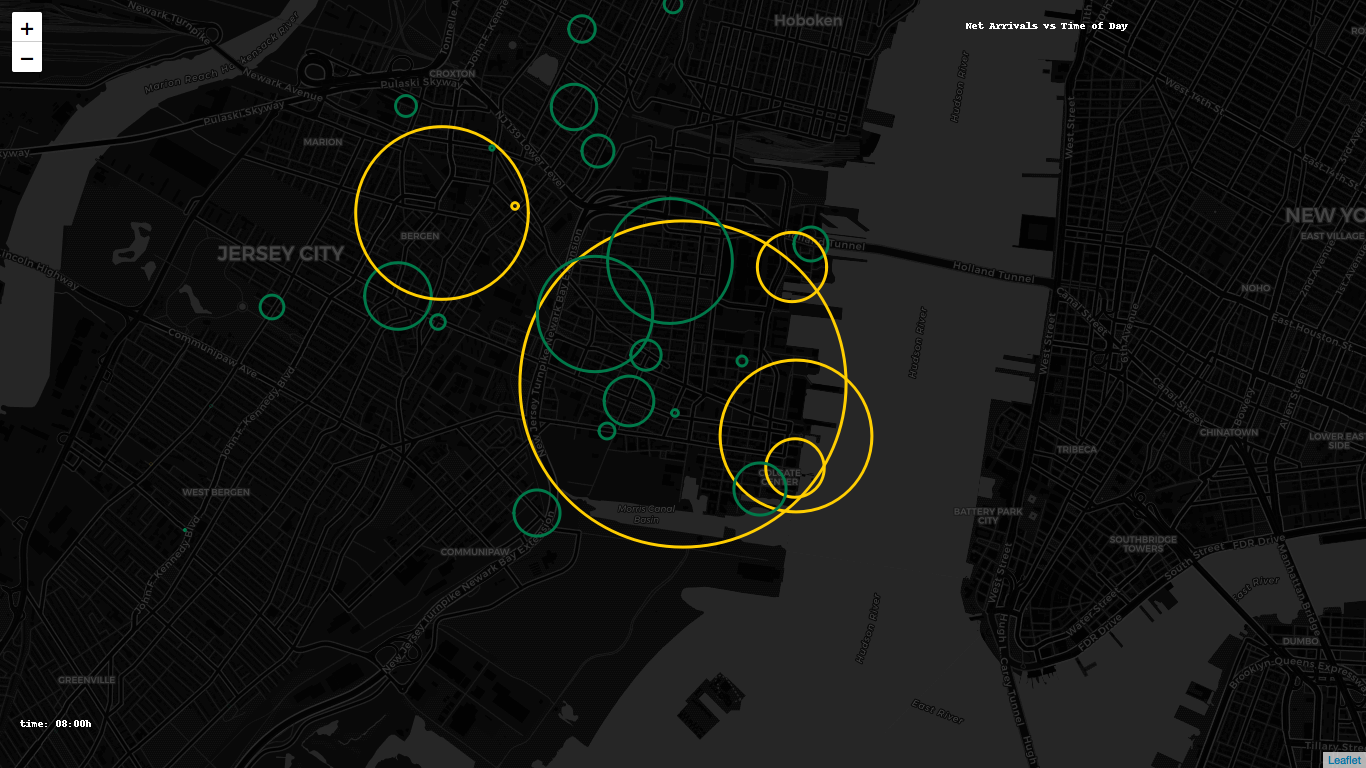

In [35]:
go_arrivals_frame(1, 8, "frames")

In [36]:
arrival_times = np.arange(6, 23, 1)
for i, hour in enumerate(arrival_times):
    go_arrivals_frame(i, hour, "frames")

/usr/local/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '
/usr/local/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '
/usr/local/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selenium support for PhantomJS has been deprecated, please use headless versions of Chrome or Firefox instead
  warnings.warn('Selenium support for PhantomJS has been deprecated, please use headless '
/usr/local/lib/python3.6/site-packages/selenium/webdriver/phantomjs/webdriver.py:49: UserWarning: Selen

In [38]:
# This command makes .mp4 animated maps out of frames 
# ! ffmpeg -r 10 -i frames/frame_%05d.png -c:v libx264 -vf fps=5 -crf 17 -pix_fmt yuv420p output.mp4

![gif](output.gif)

- Green circle where net departure > 0 and yellow circle where net departure < 0
- It's interesting to see the same station in yello once turning into green and vice versa. 